In [1]:
import os

import healpy as hp
import numpy as np
import skyproj
import proplot as pplt
import matplotlib.pyplot as plt

import rubin_sim
from rubin_sim import maf
from rubin_sim.scheduler.utils import Sky_area_generator
from rubin_sim.utils import raDec2Hpid

In [2]:
import numpy as np


def mad(x, axis=None, no_scale=False):
    """
    median absolute deviation - scaled like a standard deviation

        mad = 1.4826*median(|x-median(x)|)

    Parameters
    ----------
    x: array-like
        array to take MAD of
    axis: int
        axis over which to take mode (default: None)
    no_scale: bool
        return MAD not scaled to match a Gaussian (default: False)

    Returns
    -------
    mad: float
        MAD of array x
    """
    kd = True if axis is not None else False
    mad = np.median(np.abs(x - np.median(x, axis=axis, keepdims=kd)), axis=axis)
    if no_scale:
        return mad
    else:
        return 1.4826 * mad

In [3]:
def _run_metric(*, nside, filename, bins):
    metric = maf.RIZDetectionCoaddExposureTime(bins=bins)
    runname = os.path.basename(filename).replace('.db', '')
    slicer = maf.HealpixSlicer(nside=nside, useCache=False)
    sql = 'note not like "%%DD%%" and night <= 3653 '
    bundle = maf.MetricBundle(metric, slicer, sql, runName=runname)
    bg = maf.MetricBundleGroup([bundle], filename, '.', None)
    bg.runAll()
    return bundle.metricValues.copy()

In [4]:
def _apply_wfd_mask(maps):
    maps.mask = True
    maps.mask[wfd_indx] = False
    maps.mask[maps < 0] = True
    return maps

In [5]:
%%time

import joblib

nside = 128
bins = np.linspace(0, 3653, 41)

sm = Sky_area_generator(nside=nside)
footprints_hp_array, labels = sm.return_maps()
wfd_indx = np.where((labels == 'lowdust') | (labels == 'virgo'))[0]

filename = os.path.expandvars(
    os.path.join(
        "${RUBIN_SIM_DATA_DIR}",
        'matts_extra_sims',
        'baseline_v2.0_10yrs.db',
    ),
)
maps_arr = _run_metric(nside=nside, filename=filename, bins=bins).T

filename = os.path.expandvars(
    os.path.join(
        "${RUBIN_SIM_DATA_DIR}",
        'matts_extra_sims',
        'noroll_v2.0_10yrs.db',
    ),
)
noroll_maps_arr = _run_metric(nside=nside, filename=filename, bins=bins).T

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying table None with constraint note not like "%%DD%%" and night <= 3653  for columns ['rotSkyPos', 'fieldRA', 'night', 'filter', 'fieldDec', 'visitExposureTime']
Found 1992714 visits
Running:  ['baseline_v2_0_10yrs_riz_detcoadd_exptime_note_not_like_DD_and_night_lt_3653_HEAL']
Processing slices: 100%|██████████████| 196608/196608 [08:15<00:00, 396.88it/s]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying table None with constraint note not like "%%DD%%" and night <= 3653  for columns ['rotSkyPos', 'fieldRA', 'night', 'filter', 'fieldDec', 'visitExposureTime']
Found 1989313 visits
Running:  ['noroll_v2_0_10yrs_riz_detcoadd_exptime_note_not_like_DD_and_night_lt_3653_HEAL']
Processing slices: 100%|██████████████| 196608/196608 [06:54<00:00, 474.06it/s]
Completed metric generation.
Run

In [6]:
flost = []
med = []
sd = []
pts = []
alost = []
area = []
etime = []
for i in range(len(maps_arr)):
    maps = maps_arr[i].copy()
    maps = _apply_wfd_mask(maps)

    noroll_maps = noroll_maps_arr[i].copy()
    noroll_maps = _apply_wfd_mask(noroll_maps)

    fmaps = maps.filled(fill_value=-1)
    fnoroll_maps = noroll_maps.filled(fill_value=-1)
    fmaps = fmaps[fmaps > 15]
    fnoroll_maps = fnoroll_maps[fnoroll_maps > 15]
    
    med.append([
        np.median(fmaps), np.median(fnoroll_maps)
    ])
    sd.append([
        mad(fmaps), mad(fnoroll_maps)
    ])
    
    noroll_pt = np.percentile(fnoroll_maps[fnoroll_maps > 15], [5])
    pt = np.percentile(fmaps[fmaps > 15], [5])
    etime.append([pt, noroll_pt])
    pts.append([pt[0], noroll_pt[0]])
    
    flost.append(
        ((noroll_pt - pt)/noroll_pt)[0] if noroll_pt[0] > pt[0] else 0.0
    )

    mn = np.median(fnoroll_maps)
    _sd = mad(fnoroll_maps)
    cut = mn-3*_sd
    noroll_a = np.sum(fnoroll_maps > cut)
    a = np.sum(fmaps > cut)
    alost.append((noroll_a - a)/noroll_a)

    area.append([a, noroll_a])

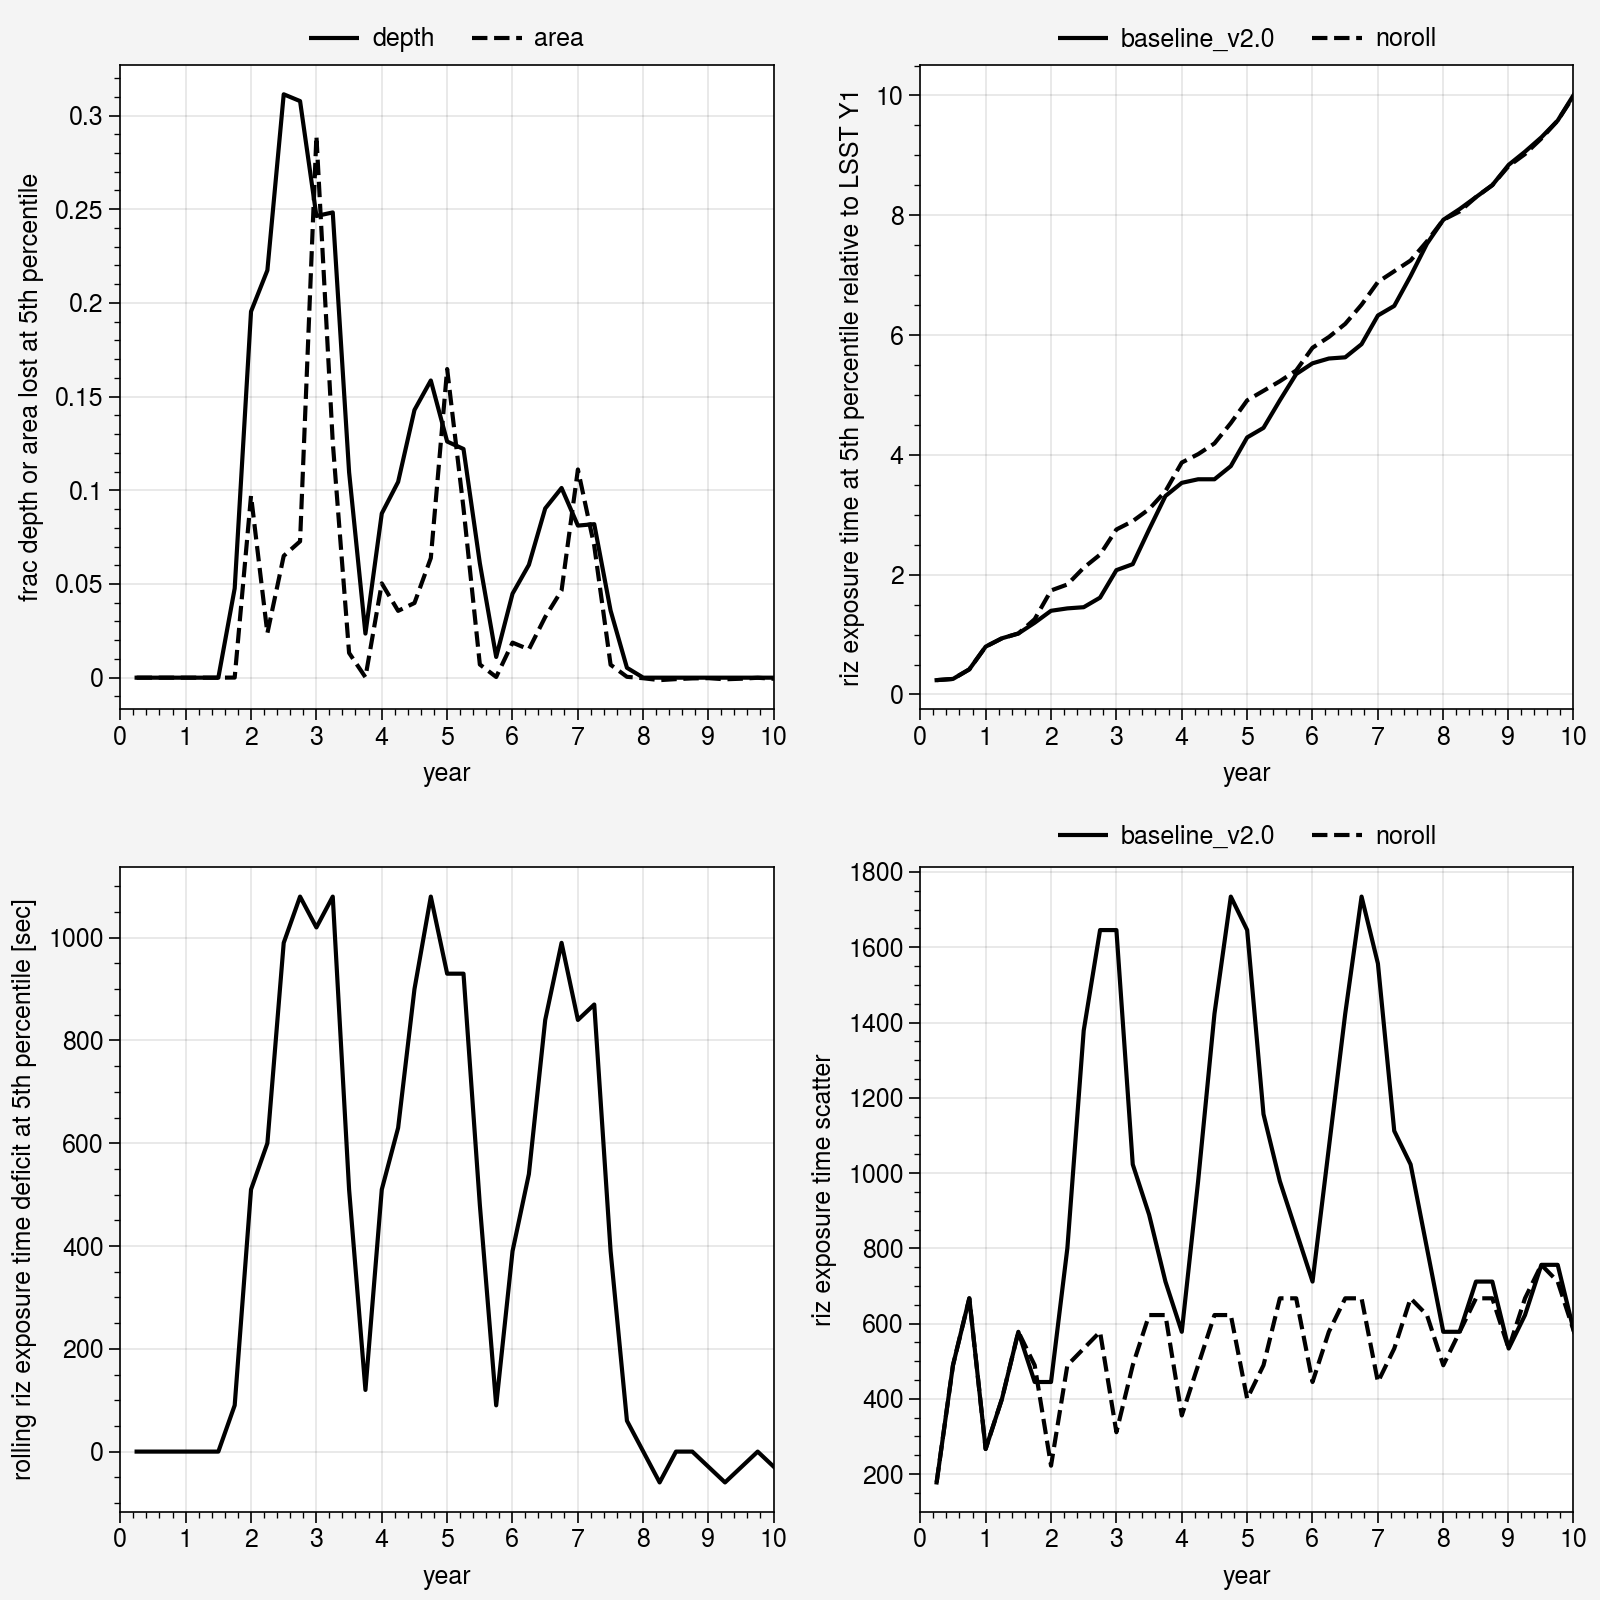

In [19]:
import proplot as pplt

fig, axs = pplt.subplots(ncols=2, nrows=2, figsize=(8, 8), sharey=0, sharex=0)

xy = np.linspace(0, 3653, 41)[1:]/365
axs[0, 0].plot(xy, np.array(flost), 'k', label="depth")
axs[0, 0].plot(xy, np.array(alost), 'k--', label="area")
axs[0, 0].set_ylabel("frac depth or area lost at 5th percentile")
axs[0, 0].legend(loc='t', frameon=False)

axs[0, 1].plot(xy, np.array(etime)[:, 0]/(np.array(etime)[-1, 1]/10), 'k', label="baseline_v2.0")
axs[0, 1].plot(xy, np.array(etime)[:, 1]/(np.array(etime)[-1, 1]/10), 'k--', label="noroll")
# axs[1].plot(xy, np.array(area)[:, 0]/np.array(area)[3, 1], 'k', label="area")
axs[0, 1].set_ylabel("riz exposure time at 5th percentile relative to LSST Y1")
axs[0, 1].legend(loc="t", frameon=False)

axs[1, 0].plot(xy, np.array(pts)[:, 1] - np.array(pts)[:, 0], 'k')
axs[1, 0].set_ylabel("rolling riz exposure time deficit at 5th percentile [sec]")

axs[1, 1].plot(xy, np.array(sd)[:, 0], 'k', label='baseline_v2.0')
axs[1, 1].plot(xy, np.array(sd)[:, 1], 'k--', label='noroll')
axs[1, 1].set_ylabel("riz exposure time scatter")
axs[1, 1].legend(loc="t", frameon=False)

for ax in axs:
    ax.set_xlim(0, 10)
    ax.set_xlabel("year")
    ax.format(xticks=np.arange(0, 11))

In [13]:
for i, a in enumerate(alost):
    if a < 0.01:
        print(bins[1+i]/365, i, a, sd[i][0]/sd[i][1])

0.2502054794520548 0 0.0 1.0
0.5004109589041096 1 0.0 1.0
0.7506164383561644 2 0.0 1.0
1.0008219178082192 3 0.0 1.0
1.251027397260274 4 0.0 1.0
1.5012328767123289 5 0.0 1.0
1.7514383561643836 6 6.168422610969923e-05 0.9090909090909091
3.753082191780822 14 0.0002347040875569775 1.1428571428571428
5.504520547945206 21 0.007043299581610675 1.4666666666666668
5.75472602739726 22 0.00035896420260434717 1.2666666666666668
7.506164383561644 29 0.006900574634182667 1.5333333333333332
7.756369863013699 30 0.00045955311564592054 1.2857142857142856
8.006575342465753 31 -0.0002993377153048879 1.1818181818181817
8.256780821917808 32 -0.0013077593722755014 1.0
8.506986301369864 33 -0.0007707703974440259 1.0666666666666667
8.757191780821918 34 -0.00038531334675715313 1.0666666666666667
9.007397260273974 35 -0.0002618911031850947 1.0
9.257602739726028 36 -0.0008585399843223133 0.9333333333333333
9.507808219178083 37 -0.0005467128887563525 1.0
9.758013698630137 38 -4.97320684810583e-05 1.0625
10.008219

365.3 [1200. 1260. 1320. 1350.] [0. 0. 0. 0.]
1369.875 [5100. 5250. 5370. 5460.] [120.  90.  60.  60.]
2100.475 [8130. 8340. 8460. 8580.] [90. 60. 30. 30.]
2831.0750000000003 [11370. 11610. 11760. 11880.] [60. 60. 60. 30.]
3653.0 [15030. 15270. 15420. 15540.] [-30. -30. -30. -30.]


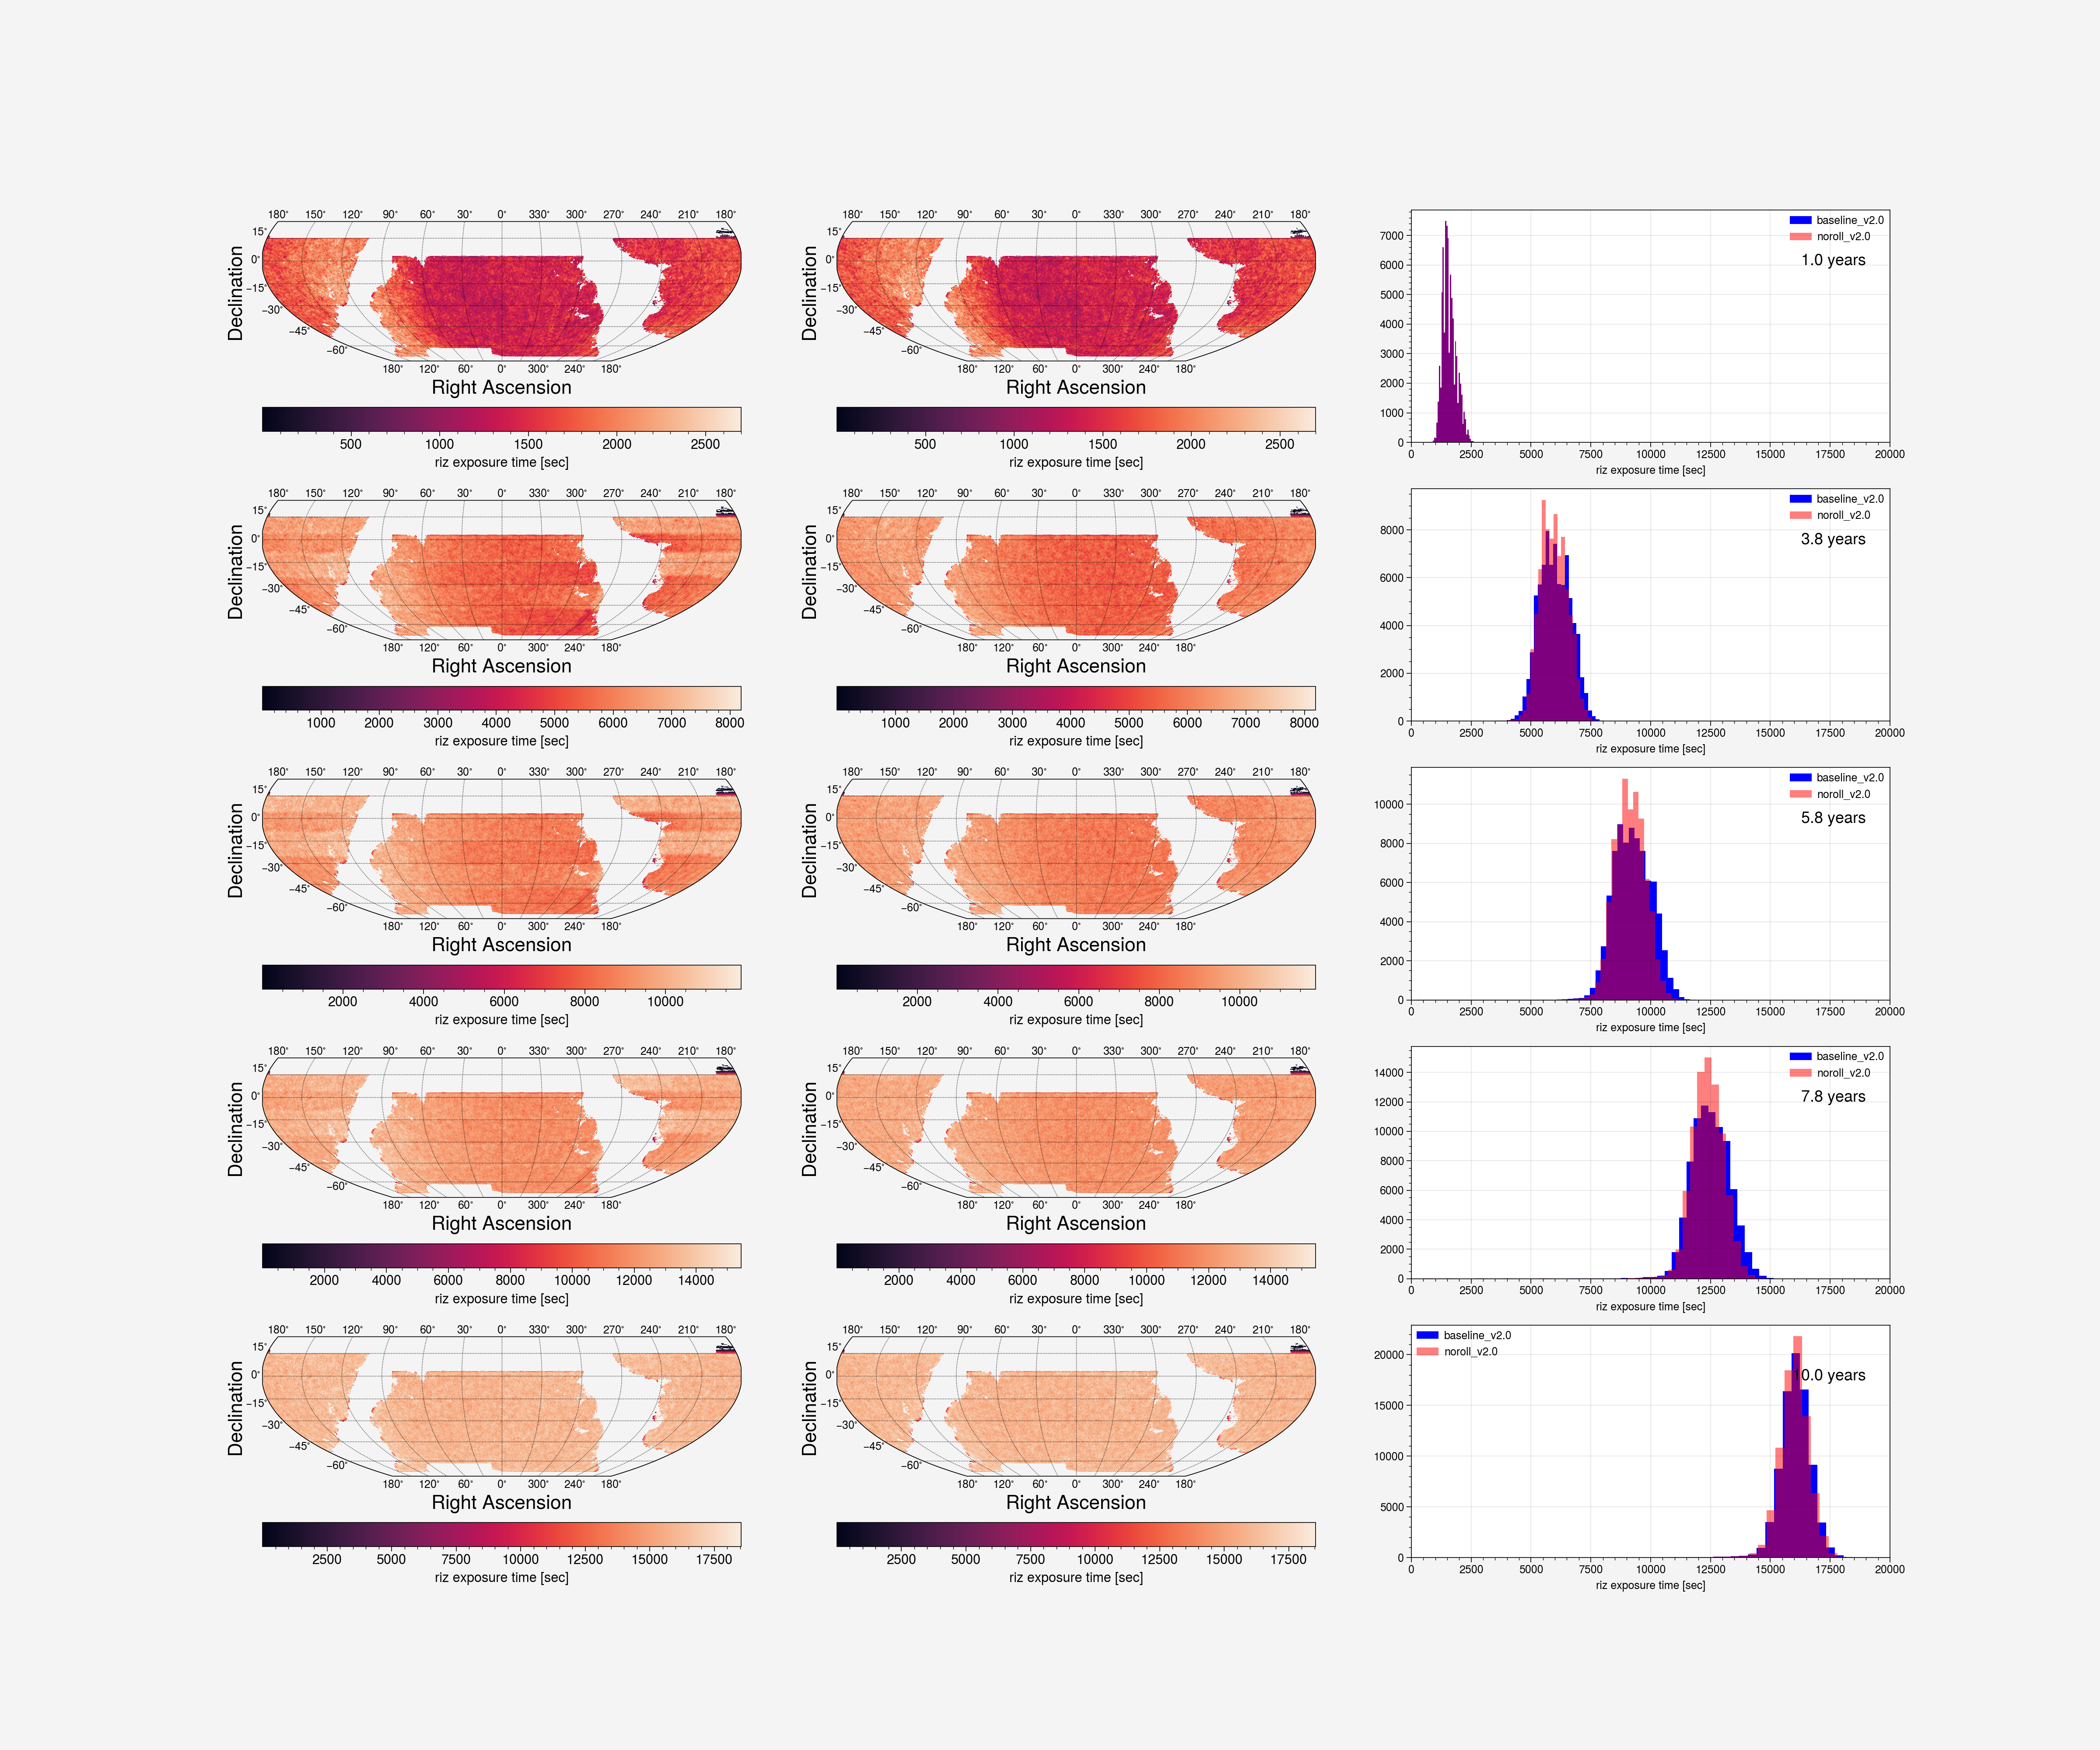

In [20]:
map_inds = [3, 14, 22, 30, 39] # np.arange(10, dtype=int)*4 + 3

fig, axs = plt.subplots(nrows=len(map_inds), ncols=3, figsize=(24, 4*len(map_inds)))

for i, map_ind in enumerate(map_inds):
    maps = maps_arr[map_ind, :].copy()
    maps = _apply_wfd_mask(maps)

    noroll_maps = noroll_maps_arr[map_ind, :].copy()
    noroll_maps = _apply_wfd_mask(noroll_maps)

    fmaps = maps.filled(fill_value=-1)
    fnoroll_maps = noroll_maps.filled(fill_value=-1)
    
    vmin = np.min([
        np.min(fmaps[fmaps > 0]),
        np.min(fnoroll_maps[fnoroll_maps > 0]),
    ])
    vmax = np.max([
        np.max(fmaps[fmaps > 0]),
        np.max(fnoroll_maps[fnoroll_maps > 0]),
    ])

    ax = axs[i, 0]
    sp = skyproj.McBrydeSkyproj(ax=ax)
    sp.draw_hpxmap(maps, vmin=vmin, vmax=vmax, cmap="rocket")
    sp.draw_colorbar(location='bottom', label='riz exposure time [sec]', pad=0.2)

    ax = axs[i, 1]
    sp = skyproj.McBrydeSkyproj(ax=ax)
    sp.draw_hpxmap(noroll_maps, vmin=vmin, vmax=vmax, cmap="rocket")
    sp.draw_colorbar(location='bottom', label='riz exposure time [sec]', pad=0.2)
    
    ax = axs[i, 2]
    ax.hist(fmaps[fmaps > 15], bins=50, color='b', label="baseline_v2.0")
    _h = ax.hist(fnoroll_maps[fnoroll_maps > 15], bins=50, alpha=0.5, color='r', label="noroll_v2.0")[0]
    ax.set_xlim(0, 20000)
    ax.set_xlabel("riz exposure time [sec]")
    ax.legend(frameon=False)
    #ax.set_title("%d nights" % bins[1+map_ind], size="x-large", pad=-6)
    ax.text(20000*0.95, np.max(_h)*0.8, "%0.1f years" % (bins[1+map_ind]/365), size="x-large", ha="right")
    
    print(
        bins[1+map_ind],
        np.percentile(fnoroll_maps[fnoroll_maps > 15], [5, 10, 15, 20]),
        np.percentile(fnoroll_maps[fnoroll_maps > 15], [5, 10, 15, 20])
        - np.percentile(fmaps[fmaps > 15], [5, 10, 15, 20])
    )
    
fig.savefig("maps.png", dpi=100)

In [ ]:
skyproj.McBrydeSkyproj?

In [ ]:
fmaps = maps.filled(fill_value=-1)
fnoroll_maps = noroll_maps.filled(fill_value=-1)

fig, axs = plt.subplots(nrows=1, ncols=1)
ax = axs

ax.hist(fmaps[fmaps > 0], bins=50, color='b', density=True)
# mn = np.median(maps[maps > 0])
# sd = mad(maps[maps > 0])
# ax.axvline(mn-4*sd, color='b', linestyle='dashed')
# ax.axvline(mn, color='b', linestyle='solid')

ax.hist(fnoroll_maps[fnoroll_maps > 0], bins=50, alpha=0.5, density=True, color='r')
# nr_mn = np.median(noroll_maps[noroll_maps > 0])
# nr_sd = mad(noroll_maps[noroll_maps > 0])
# ax.axvline(nr_mn-4*nr_sd, color='r', linestyle='dashed')
# ax.axvline(nr_mn, color='r', linestyle='solid')

In [ ]:
nr_mn - 4*nr_sd - (mn - 4*sd)

In [ ]:
v = np.percentile(noroll_maps[noroll_maps > 0], [5])

In [ ]:
sp.draw_colorbar?

In [ ]:
np.any(maps != noroll_maps)

In [ ]:
maps[~maps.mask]

In [ ]:
noroll_maps[~noroll_maps.mask]

In [ ]:
if np.isin(2, np.arange(4)):
    print("yay")

In [ ]:
sp.draw_colorbar?

In [ ]:
filename = 'noroll_v2.2_10yrs.db'
runname = filename.split('/')[-1].replace('.db', '')
bins = np.arange(0,3653, 20)
# Make a map over the whole sky
slicer = maf.HealpixSlicer()
# just count how many observations overlap the point
metric = maf.AccumulateM5Metric(bins=bins)
# limit the data to just things on one night
sql='filter="r" and note not like "%%DD%%" '
bundle = maf.MetricBundle(metric, slicer, sql, runName=runname)
bg = maf.MetricBundleGroup([bundle], filename, '.', None)
bg.runAll()

noroll_depths =  bundle.metricValues.copy()

In [ ]:
nside=128
sm = Sky_area_generator(nside=nside)
footprints_hp_array, labels = sm.return_maps()
wfd_indx = np.where((labels == 'lowdust') | (labels == 'LMC_SMC') | (labels == 'virgo'))[0]
mask = np.zeros(labels.size, dtype=float) + np.nan
mask[wfd_indx] = 1

baseline_depths *= mask[:,np.newaxis]
noroll_depths *= mask[:,np.newaxis]


baseline_depths.mask = True
baseline_depths.mask[wfd_indx] = False

noroll_depths.mask = True
noroll_depths.mask[wfd_indx] = False


In [ ]:
hp.mollview(baseline_depths[:,100])

In [ ]:
hp.mollview(noroll_depths[:,100])

In [ ]:
bins[100]/365

In [ ]:
plt.plot(bins[1:], np.nanmin(baseline_depths, axis=0), label='rolling')
plt.plot(bins[1:], np.nanmin(noroll_depths, axis=0), label='uniform')

plt.xlabel('Night')
plt.ylabel('Minimum WFD Coadded Depth in r (mags)')
plt.legend()
plt.ylim([24,26])
plt.savefig('min_wfd.png')

In [ ]:
centile = 5

temp = baseline_depths.data
temp[np.where(temp <= 0)] = np.nan

plt.plot(bins[1:], np.nanpercentile(temp, centile, axis=0), label='rolling')

temp = noroll_depths.data
temp[np.where(temp <= 0)] = np.nan

plt.plot(bins[1:], np.nanpercentile(temp, centile, axis=0), label='uniform')

plt.xlabel('Night')
plt.ylabel('%ith percentile WFD Coadded Depth in r (mags)' % centile)
plt.legend()
plt.ylim([24,27])
plt.savefig('5th_wfd.png')

In [ ]:
centile = 95

temp = baseline_depths.data
temp[np.where(temp <= 0)] = np.nan

plt.plot(bins[1:], np.nanpercentile(temp, centile, axis=0), label='rolling')

temp = noroll_depths.data
temp[np.where(temp <= 0)] = np.nan

plt.plot(bins[1:], np.nanpercentile(temp, centile, axis=0), label='uniform')

plt.xlabel('Night')
plt.ylabel('%ith percentile WFD Coadded Depth in r (mags)' % centile)
plt.legend()
plt.ylim([25,27.5])

In [ ]:
# Let's look at a single healpixel
indx = raDec2Hpid(nside, 0,-10,)
plt.plot(bins[1:], baseline_depths[indx,:], label='rolling')
plt.plot(bins[1:], noroll_depths[indx,:], label='uniform')
plt.legend()

In [ ]:
# Let's look at a single healpixel
indx = raDec2Hpid(nside, 0,-40)
plt.plot(bins[1:], baseline_depths[indx,:], label='rolling')
plt.plot(bins[1:], noroll_depths[indx,:], label='uniform')
plt.legend()